In [1]:
import os
import glob
import json
from itertools import product
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)
plt.rc('legend',fontsize='large')
plt.rc('axes',labelsize='x-large')
plt.rc('text',usetex='true')
plt.rc('xtick', labelsize='large')
import seaborn as sns
import joblib
from packages.constants import HOME_PATH, STEP_PREFIX
from packages.utils import get_electron_label, get_jet_label
import packages.plotting as plotting
%matplotlib inline

Welcome to JupyROOT 6.16/00
Using all sub packages with ROOT dependence


In [2]:
SHOWER_SHAPES = {
    'reta': {
        'label': '$R_{eta}$',
        'range': (0,1),
        'electron_range': (0.82, 1),
        'jet_range': (0.6,1),
        'step': 'L2Calo'
    },
    'eratio': {
        'label': '$E_{ratio}$',
        'range': (0,1),
        'electron_range': (0.9, 1),
        'jet_range': (0,1),
        'step': 'L2Calo'
    },
    'f1': {
        'label': '$f_1$',
        'range': (0,1),
        'electron_range': None,
        'jet_range': None,
        'step': 'L2Calo'
    },
    'ehad1': {
        'label': '$E_{had1}$',
        'range': None,
        'electron_range': None,
        'jet_range': None,
        'step': 'L2Calo'
    },
    'f3': {
        'label': '$f_3$',
        'range': (0,1),
        'electron_range': None,
        'jet_range': None,
        'step': 'L2Calo'
    },
    'weta2': {
        'label': '$\omega_{\eta 2}$',
        'range': None,
        'electron_range': None,
        'jet_range': None,
        'step': 'L2Calo'
    },
    'wstot': {
        'label': '$\omega_{stot}$',
        'range': None,
        'electron_range': None,
        'jet_range': None,
        'step': 'L2Calo'
    },
    'e2tsts1': {
        'label': 'no label',
        'range': None,
        'electron_range': None,
        'jet_range': None,
        'step': 'L2Calo'
    }
}
HIST_DF_COLS = ['bin_start', 'bin_end', 'hist']

In [3]:
def subsample_hist_df(hist_df, subsample):
    subsampled_hist_df = hist_df.reset_index()
    subsampled_hist_df['group'] = subsampled_hist_df['index'] // subsample
    agg_dict = dict(hist='sum', bin_start='min', bin_end='max')
    subsampled_hist_df = subsampled_hist_df.groupby('group') \
        .agg(agg_dict).dropna().reset_index(drop=True)
    # Renormalizing
    area = get_hist_area(subsampled_hist_df)
    subsampled_hist_df['hist'] = subsampled_hist_df['hist']/area
    return subsampled_hist_df

In [4]:
def get_hist_area(hist_df):
    return (hist_df['hist'] * (hist_df['bin_end'] - hist_df['bin_start'])).sum()

## Distribution plots

### Loading data

In [5]:
plot_cols = list()
step='L2Calo'
datapath = os.path.join(HOME_PATH, 'data')
collision_path = os.path.join(datapath, 'ided_data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM1.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.25bins.parquet', 
                              'ided_data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM1.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.25bins.parquet_et4_eta4.parquet')
boosted_path = os.path.join(datapath, 'ided_mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins.v2.parquet')

shower_shapes = [STEP_PREFIX[step] + ss for ss in SHOWER_SHAPES.keys()]
shower_shapes

['trig_L2_cl_reta',
 'trig_L2_cl_eratio',
 'trig_L2_cl_f1',
 'trig_L2_cl_ehad1',
 'trig_L2_cl_f3',
 'trig_L2_cl_weta2',
 'trig_L2_cl_wstot',
 'trig_L2_cl_e2tsts1']

In [6]:
boosted_data = pd.read_parquet(boosted_path, columns=shower_shapes)
boosted_data.head()

,trig_L2_cl_reta,trig_L2_cl_eratio,trig_L2_cl_f1,trig_L2_cl_ehad1,trig_L2_cl_f3,trig_L2_cl_weta2,trig_L2_cl_wstot,trig_L2_cl_e2tsts1
0,0.925877,0.982229,0.286768,1626.380493,0.004404,0.010177,1.134755,24.469589
1,0.988089,0.816197,0.085186,-184.739105,0.008879,0.009084,1.250962,59.001091
2,0.935216,0.890477,0.466089,-161.464890,-0.000920,0.011774,2.881309,198.510132
3,0.962935,0.948033,0.320025,-130.190170,0.001840,0.009567,1.323367,67.998497
4,0.670090,0.138930,0.270767,5028.686035,0.011920,0.017711,6.128632,846.002319


In [7]:
add_cols = ['target', 'el_lhmedium', 'el_lhvloose']
collision_data = pd.read_parquet(collision_path, columns=shower_shapes + add_cols)
print(collision_data.shape)
jet_label = get_jet_label(collision_data, 'el_lhvloose')
collision_data['jet'] = jet_label
print(f'There are {jet_label.sum()} jets')
electron_label = get_electron_label(collision_data, 'el_lhmedium')
collision_data['electron'] = electron_label
print(f'There are {electron_label.sum()} electrons')
collision_data.drop(add_cols, axis=1, inplace=True)
collision_data.head()

(198565, 11)
There are 93785 jets
There are 89782 electrons


,trig_L2_cl_reta,trig_L2_cl_eratio,trig_L2_cl_f1,trig_L2_cl_ehad1,trig_L2_cl_f3,trig_L2_cl_weta2,trig_L2_cl_wstot,trig_L2_cl_e2tsts1,jet,electron
0,0.965098,98.999992,0.173870,289.812286,0.018926,0.015195,-9999.0000,-999.000000,False,True
1,0.919317,0.978109,0.259116,-1271.184082,0.012403,0.012845,1.5839,421.378906,False,True
2,0.929197,98.999992,0.150610,1686.973389,0.014153,0.015155,-9999.0000,-999.000000,False,False
3,0.978093,98.999992,0.081285,321.787781,0.024593,0.013731,-9999.0000,-999.000000,False,True
4,0.977637,98.999992,0.078947,-1975.292847,0.027291,0.016033,-9999.0000,-999.000000,False,True


### $E_{ratio}$

In [8]:
hists = dict()
plot_ss = 'eratio'
ss_info = SHOWER_SHAPES[plot_ss]
ss_col = STEP_PREFIX[ss_info['step']] + plot_ss

boosted_in_range = boosted_data[ss_col].between(*ss_info['range'])
boosted_bins = np.linspace(*ss_info['range'], num=1000)
boosted_hist, _ = np.histogram(boosted_data.loc[boosted_in_range, ss_col], bins=boosted_bins, density=True)
hists['MC16 Boosted el'] = pd.DataFrame(np.column_stack([boosted_bins[:-1], boosted_bins[1:], boosted_hist]),
                                        columns=HIST_DF_COLS)

collision_in_range = collision_data[ss_col].between(*ss_info['range'])
el_bins = boosted_bins
el_hist, _ = np.histogram(collision_data.loc[collision_data['electron'] & collision_in_range, ss_col], bins=el_bins, density=True)
hists['Data17 Zee el'] = pd.DataFrame(np.column_stack([el_bins[:-1], el_bins[1:], el_hist]),
                                        columns=HIST_DF_COLS)

jet_bins = el_bins
jet_hist, _ = np.histogram(collision_data.loc[collision_data['jet'] & collision_in_range, ss_col], bins=jet_bins, density=True)
hists['Data17 Zee jet'] = pd.DataFrame(np.column_stack([jet_bins[:-1], jet_bins[1:], jet_hist]),
                                        columns=HIST_DF_COLS)

Text(0.5, 1.0, '$E_{ratio}$ distribution')

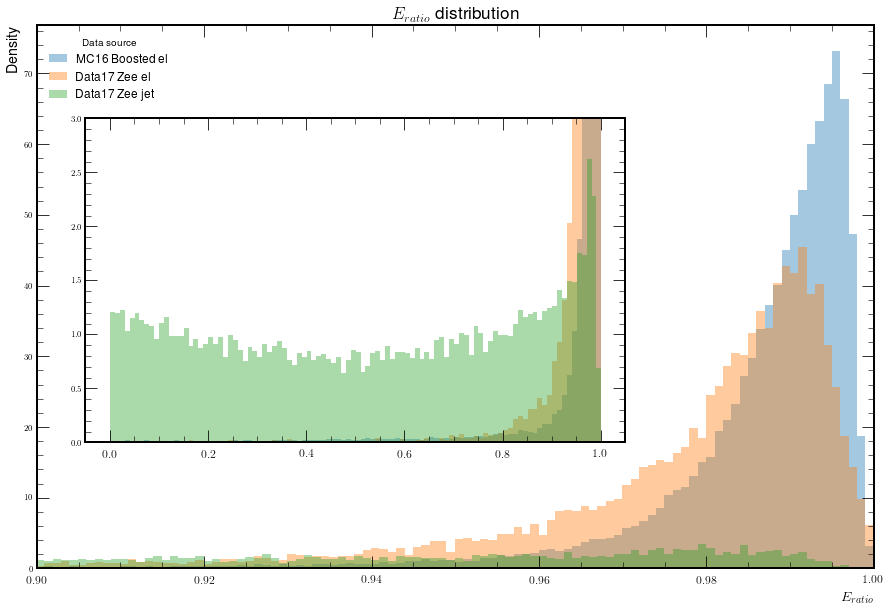

In [9]:
sub_ax_pos = [0.17, 0.3, 0.5, 0.45]
fig, ax = plt.subplots(1,1, figsize=(15,10))
zoomed_ax = fig.add_axes(sub_ax_pos)
subsampled_hists = dict()
for hist_name, hist_df in hists.items():
    ax.bar(hist_df['bin_start'], hist_df['hist'], align='edge', width=(hist_df['bin_end'] - hist_df['bin_start']), label=hist_name, alpha=0.4, bottom=0)
    subsampled_hist_df = subsample_hist_df(hist_df,10)
    subsampled_hists[hist_name] = subsampled_hist_df
    zoomed_ax.bar(subsampled_hist_df['bin_start'], subsampled_hist_df['hist'], align='edge', width=(subsampled_hist_df['bin_end'] - subsampled_hist_df['bin_start']), alpha=0.4, bottom=0)

ax.set_xlim(ss_info['electron_range'])
ax.set_ylabel('Density')
ax.set_xlabel(ss_info['label'])
ax.legend(title='Data source')
zoomed_ax.set_ylim(0,3)
ax.set_title(f'{ss_info["label"]} distribution', fontsize='xx-large')

### $R_{\eta}$

In [10]:
hists = dict()
plot_ss = 'reta'
ss_info = SHOWER_SHAPES[plot_ss]
ss_col = STEP_PREFIX[ss_info['step']] + plot_ss

boosted_in_range = boosted_data[ss_col].between(*ss_info['range'])
boosted_bins = np.linspace(*ss_info['range'], num=1000)
boosted_hist, _ = np.histogram(boosted_data.loc[boosted_in_range, ss_col], bins=boosted_bins, density=True)
hists['MC16 Boosted el'] = pd.DataFrame(np.column_stack([boosted_bins[:-1], boosted_bins[1:], boosted_hist]),
                                        columns=HIST_DF_COLS)

collision_in_range = collision_data[ss_col].between(*ss_info['range'])
el_bins = boosted_bins
el_hist, _ = np.histogram(collision_data.loc[collision_data['electron'] & collision_in_range, ss_col], bins=el_bins, density=True)
hists['Data17 Zee el'] = pd.DataFrame(np.column_stack([el_bins[:-1], el_bins[1:], el_hist]),
                                        columns=HIST_DF_COLS)

jet_bins = el_bins
jet_hist, _ = np.histogram(collision_data.loc[collision_data['jet'] & collision_in_range, ss_col], bins=jet_bins, density=True)
hists['Data17 Zee jet'] = pd.DataFrame(np.column_stack([jet_bins[:-1], jet_bins[1:], jet_hist]),
                                        columns=HIST_DF_COLS)

Text(0.5, 1.0, '$R_{eta}$ distribution')

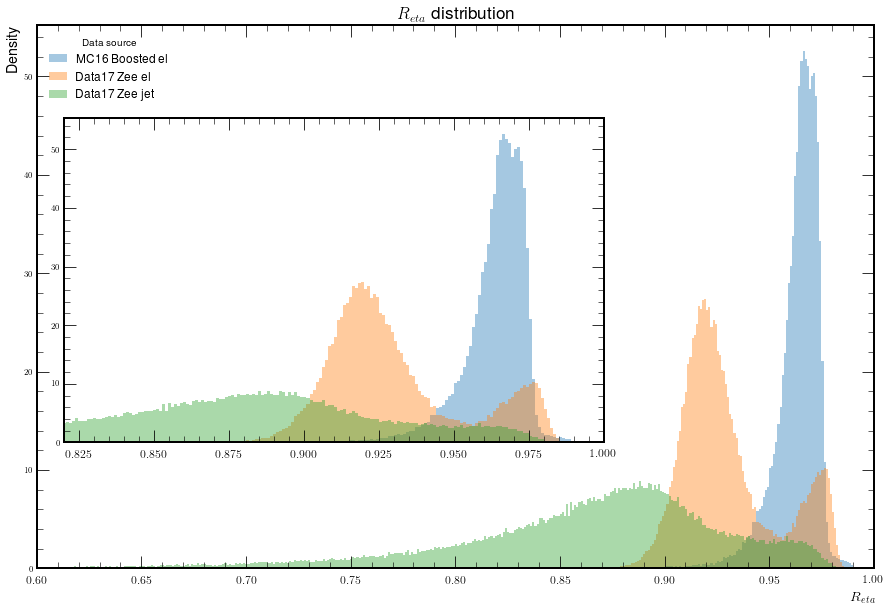

In [11]:
sub_ax_pos = [0.15, 0.3, 0.5, 0.45]
fig, ax = plt.subplots(1,1, figsize=(15,10))
zoomed_ax = fig.add_axes(sub_ax_pos)
subsampled_hists = dict()
for hist_name, hist_df in hists.items():
    ax.bar(hist_df['bin_start'], hist_df['hist'], align='edge', width=(hist_df['bin_end'] - hist_df['bin_start']), label=hist_name, alpha=0.4, bottom=0)
    zoomed_ax.bar(hist_df['bin_start'], hist_df['hist'], align='edge', width=(hist_df['bin_end'] - hist_df['bin_start']), label=hist_name, alpha=0.4, bottom=0)

ax.set_xlim(ss_info['jet_range'])
zoomed_ax.set_xlim(ss_info['electron_range'])
ax.set_ylabel('Density')
ax.set_xlabel(ss_info['label'])
ax.legend(title='Data source')
ax.set_title(f'{ss_info["label"]} distribution', fontsize='xx-large')

### $E_{had1}$

In [12]:
hists = dict()
plot_ss = 'ehad1'
ss_info = SHOWER_SHAPES[plot_ss]
ss_col = STEP_PREFIX[ss_info['step']] + plot_ss

# boosted_in_range = boosted_data[ss_col].between(*ss_info['range'])
# boosted_bins = np.linspace(*ss_info['range'], num=1000)
# boosted_hist, _ = np.histogram(boosted_data.loc[boosted_in_range, ss_col], bins=boosted_bins, density=True)
boosted_hist, boosted_bins = np.histogram(boosted_data.loc[:, ss_col], bins=8000, density=True)
hists['MC16 Boosted el'] = pd.DataFrame(np.column_stack([boosted_bins[:-1], boosted_bins[1:], boosted_hist]),
                                        columns=HIST_DF_COLS)

# collision_in_range = collision_data[ss_col].between(*ss_info['range'])
# el_bins = boosted_bins
el_hist, el_bins = np.histogram(collision_data.loc[collision_data['electron'], ss_col], bins=1000, density=True)
hists['Data17 Zee el'] = pd.DataFrame(np.column_stack([el_bins[:-1], el_bins[1:], el_hist]),
                                        columns=HIST_DF_COLS)

# jet_bins = el_bins
jet_hist, jet_bins = np.histogram(collision_data.loc[collision_data['jet'], ss_col], bins=1000, density=True)
hists['Data17 Zee jet'] = pd.DataFrame(np.column_stack([jet_bins[:-1], jet_bins[1:], jet_hist]),
                                        columns=HIST_DF_COLS)

Text(0.5, 1.0, '$E_{had1}$ distribution')

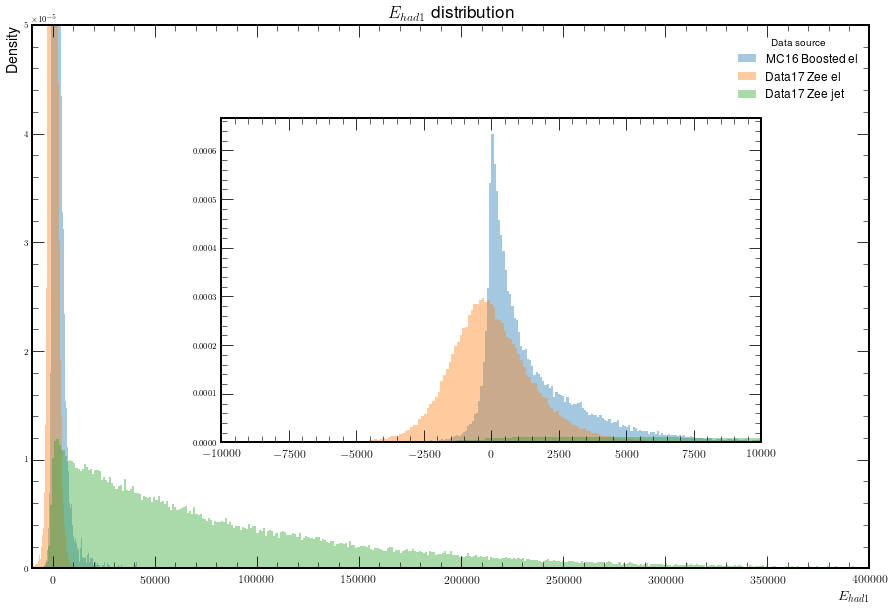

In [13]:
sub_ax_pos = [0.3, 0.3, 0.5, 0.45]
fig, ax = plt.subplots(1,1, figsize=(15,10))
zoomed_ax = fig.add_axes(sub_ax_pos)
subsampled_hists = dict()
for hist_name, hist_df in hists.items():
    ax.bar(hist_df['bin_start'], hist_df['hist'], align='edge', width=(hist_df['bin_end'] - hist_df['bin_start']), label=hist_name, alpha=0.4, bottom=0)
    zoomed_ax.bar(hist_df['bin_start'], hist_df['hist'], align='edge', width=(hist_df['bin_end'] - hist_df['bin_start']), label=hist_name, alpha=0.4, bottom=0)
ax.set_xlim(-1e4, 0.4e6)
ax.set_ylim(0, 5e-5)
zoomed_ax.set_xlim(-1e4, 1e4)
# ax.set_xlim(ss_info['jet_range'])
# zoomed_ax.set_xlim(ss_info['electron_range'])
ax.set_ylabel('Density')
ax.set_xlabel(ss_info['label'])
ax.legend(title='Data source')
ax.set_title(f'{ss_info["label"]} distribution', fontsize='xx-large')

### $f_1$

In [14]:
hists = dict()
plot_ss = 'f1'
ss_info = SHOWER_SHAPES[plot_ss]
ss_col = STEP_PREFIX[ss_info['step']] + plot_ss

boosted_in_range = boosted_data[ss_col].between(*ss_info['range'])
boosted_bins = np.linspace(*ss_info['range'], num=1000)
boosted_hist, _ = np.histogram(boosted_data.loc[boosted_in_range, ss_col], bins=boosted_bins, density=True)
boosted_hist, boosted_bins = np.histogram(boosted_data.loc[:, ss_col], bins=1000, density=True)
hists['MC16 Boosted el'] = pd.DataFrame(np.column_stack([boosted_bins[:-1], boosted_bins[1:], boosted_hist]),
                                        columns=HIST_DF_COLS)

collision_in_range = collision_data[ss_col].between(*ss_info['range'])
el_bins = boosted_bins
el_hist, el_bins = np.histogram(collision_data.loc[collision_data['electron'], ss_col], bins=el_bins, density=True)
hists['Data17 Zee el'] = pd.DataFrame(np.column_stack([el_bins[:-1], el_bins[1:], el_hist]),
                                        columns=HIST_DF_COLS)

jet_bins = el_bins
jet_hist, jet_bins = np.histogram(collision_data.loc[collision_data['jet'], ss_col], bins=jet_bins, density=True)
hists['Data17 Zee jet'] = pd.DataFrame(np.column_stack([jet_bins[:-1], jet_bins[1:], jet_hist]),
                                        columns=HIST_DF_COLS)

Text(0.5, 1.0, '$f_1$ distribution')

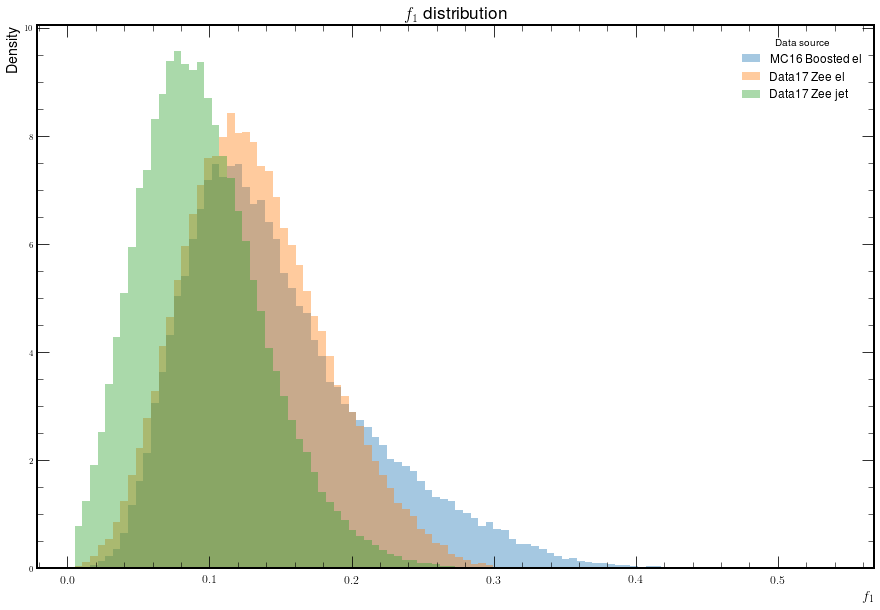

In [15]:
# sub_ax_pos = [0.3, 0.3, 0.5, 0.45]
fig, ax = plt.subplots(1,1, figsize=(15,10))
# zoomed_ax = fig.add_axes(sub_ax_pos)
subsampled_hists = dict()
for hist_name, hist_df in hists.items():
    subsampled_hist_df = subsample_hist_df(hist_df,10)
    subsampled_hists[hist_name] = subsampled_hist_df
    ax.bar(subsampled_hist_df['bin_start'], subsampled_hist_df['hist'], align='edge', width=(subsampled_hist_df['bin_end'] - subsampled_hist_df['bin_start']), label=hist_name, alpha=0.4, bottom=0)
    # ax.bar(hist_df['bin_start'], hist_df['hist'], align='edge', width=(hist_df['bin_end'] - hist_df['bin_start']), label=hist_name, alpha=0.4, bottom=0)
    # zoomed_ax.bar(subsampled_hist_df['bin_start'], subsampled_hist_df['hist'], align='edge', width=(subsampled_hist_df['bin_end'] - subsampled_hist_df['bin_start']), alpha=0.4, bottom=0)
    #zoomed_ax.bar(hist_df['bin_start'], hist_df['hist'], align='edge', width=(hist_df['bin_end'] - hist_df['bin_start']), label=hist_name, alpha=0.4, bottom=0)
# ax.set_xlim(-0.01, 0.2)
# ax.set_ylim(0, 5e-5)
# # ax.set_xlim(ss_info['jet_range'])
# zoomed_ax.set_xlim(-0.01,0.075)
ax.set_ylabel('Density')
ax.set_xlabel(ss_info['label'])
ax.legend(title='Data source')
ax.set_title(f'{ss_info["label"]} distribution', fontsize='xx-large')

### $f_3$

In [16]:
hists = dict()
plot_ss = 'f3'
ss_info = SHOWER_SHAPES[plot_ss]
ss_col = STEP_PREFIX[ss_info['step']] + plot_ss

boosted_in_range = boosted_data[ss_col].between(*ss_info['range'])
boosted_bins = np.linspace(*ss_info['range'], num=1000)
boosted_hist, _ = np.histogram(boosted_data.loc[boosted_in_range, ss_col], bins=boosted_bins, density=True)
boosted_hist, boosted_bins = np.histogram(boosted_data.loc[:, ss_col], bins=1000, density=True)
hists['MC16 Boosted el'] = pd.DataFrame(np.column_stack([boosted_bins[:-1], boosted_bins[1:], boosted_hist]),
                                        columns=HIST_DF_COLS)

collision_in_range = collision_data[ss_col].between(*ss_info['range'])
el_bins = boosted_bins
el_hist, el_bins = np.histogram(collision_data.loc[collision_data['electron'], ss_col], bins=el_bins, density=True)
hists['Data17 Zee el'] = pd.DataFrame(np.column_stack([el_bins[:-1], el_bins[1:], el_hist]),
                                        columns=HIST_DF_COLS)

jet_bins = el_bins
jet_hist, jet_bins = np.histogram(collision_data.loc[collision_data['jet'], ss_col], bins=jet_bins, density=True)
hists['Data17 Zee jet'] = pd.DataFrame(np.column_stack([jet_bins[:-1], jet_bins[1:], jet_hist]),
                                        columns=HIST_DF_COLS)

Text(0.5, 1.0, '$f_3$ distribution')

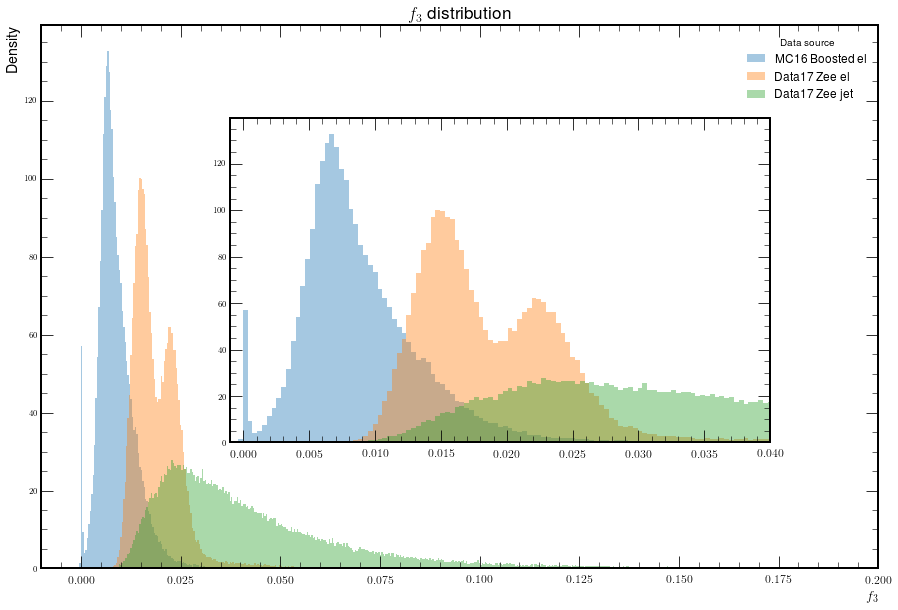

In [17]:
sub_ax_pos = [0.3, 0.3, 0.5, 0.45]
fig, ax = plt.subplots(1,1, figsize=(15,10))
zoomed_ax = fig.add_axes(sub_ax_pos)
subsampled_hists = dict()
for hist_name, hist_df in hists.items():
    # subsampled_hist_df = subsample_hist_df(hist_df,10)
    # subsampled_hists[hist_name] = subsampled_hist_df
    # ax.bar(subsampled_hist_df['bin_start'], subsampled_hist_df['hist'], align='edge', width=(subsampled_hist_df['bin_end'] - subsampled_hist_df['bin_start']), label=hist_name, alpha=0.4, bottom=0)
    ax.bar(hist_df['bin_start'], hist_df['hist'], align='edge', width=(hist_df['bin_end'] - hist_df['bin_start']), label=hist_name, alpha=0.4, bottom=0)
    #zoomed_ax.bar(subsampled_hist_df['bin_start'], subsampled_hist_df['hist'], align='edge', width=(subsampled_hist_df['bin_end'] - subsampled_hist_df['bin_start']), alpha=0.4, bottom=0)
    zoomed_ax.bar(hist_df['bin_start'], hist_df['hist'], align='edge', width=(hist_df['bin_end'] - hist_df['bin_start']), label=hist_name, alpha=0.4, bottom=0)
ax.set_xlim(-0.01, 0.2)
# ax.set_ylim(0, 5e-5)
# # ax.set_xlim(ss_info['jet_range'])
zoomed_ax.set_xlim(-0.001,0.04)
ax.set_ylabel('Density')
ax.set_xlabel(ss_info['label'])
ax.legend(title='Data source')
ax.set_title(f'{ss_info["label"]} distribution', fontsize='xx-large')

### $\omega_{\eta 2}$

In [18]:
hists = dict()
plot_ss = 'weta2'
ss_info = SHOWER_SHAPES[plot_ss]
ss_col = STEP_PREFIX[ss_info['step']] + plot_ss

# boosted_in_range = boosted_data[ss_col].between(*ss_info['range'])
# boosted_bins =  np.linspace(0.007, 0.0071, num=10)
boosted_bins = np.linspace(0, 0.02, num=1000)
# boosted_hist, _ = np.histogram(boosted_data.loc[boosted_in_range, ss_col], bins=boosted_bins, density=True)
boosted_hist, boosted_bins = np.histogram(boosted_data.loc[:, ss_col], bins=boosted_bins, density=True)
hists['MC16 Boosted el'] = pd.DataFrame(np.column_stack([boosted_bins[:-1], boosted_bins[1:], boosted_hist]),
                                        columns=HIST_DF_COLS)

# collision_in_range = collision_data[ss_col].between(*ss_info['range'])
el_bins = np.linspace(0, 0.02, num=1000)
el_hist, el_bins = np.histogram(collision_data.loc[collision_data['electron'], ss_col], bins=el_bins, density=True)
hists['Data17 Zee el'] = pd.DataFrame(np.column_stack([el_bins[:-1], el_bins[1:], el_hist]),
                                        columns=HIST_DF_COLS)

jet_bins = np.linspace(0, 0.06, num=1000)
jet_hist, jet_bins = np.histogram(collision_data.loc[collision_data['jet'], ss_col], bins=jet_bins, density=True)
hists['Data17 Zee jet'] = pd.DataFrame(np.column_stack([jet_bins[:-1], jet_bins[1:], jet_hist]),
                                        columns=HIST_DF_COLS)

Text(0.5, 1.0, '$\\omega_{\\eta 2}$ distribution')

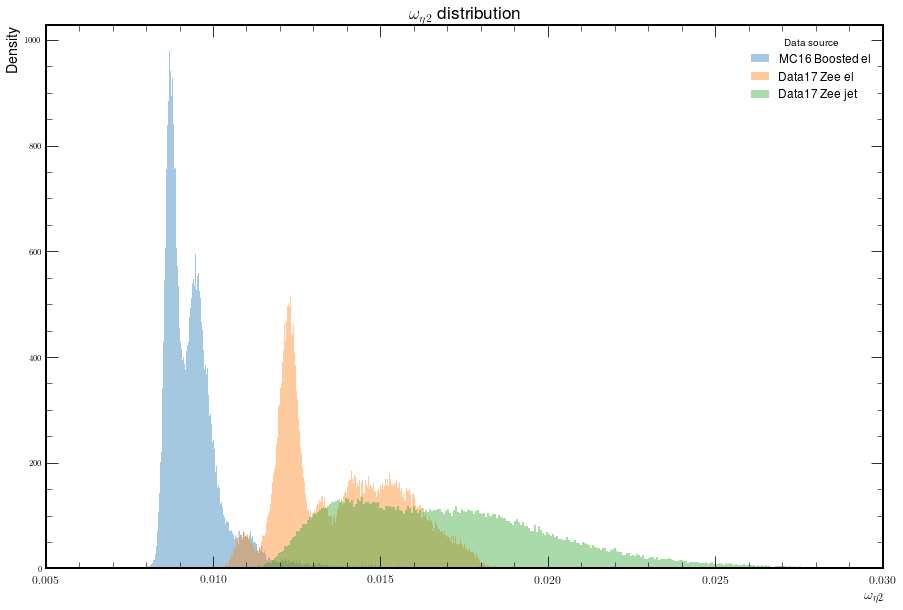

In [19]:
# sub_ax_pos = [0.3, 0.3, 0.5, 0.45]
fig, ax = plt.subplots(1,1, figsize=(15,10))
# zoomed_ax = fig.add_axes(sub_ax_pos)
subsampled_hists = dict()
for hist_name, hist_df in hists.items():
    ax.bar(hist_df['bin_start'], hist_df['hist'], align='edge', width=(hist_df['bin_end'] - hist_df['bin_start']), label=hist_name, alpha=0.4, bottom=0)
#     zoomed_ax.bar(hist_df['bin_start'], hist_df['hist'], align='edge', width=(hist_df['bin_end'] - hist_df['bin_start']), label=hist_name, alpha=0.4, bottom=0)
# ax.set_xlim(-1e4, 0.4e6)
# ax.set_ylim(0, 5e-5)
# zoomed_ax.set_xlim(-1e4, 1e4)
# ax.set_xlim(ss_info['jet_range'])
# zoomed_ax.set_xlim(ss_info['electron_range'])
ax.set_xlim(5e-3,0.03)
ax.set_ylabel('Density')
ax.set_xlabel(ss_info['label'])
ax.legend(title='Data source')
ax.set_title(f'{ss_info["label"]} distribution', fontsize='xx-large')

### $w_{stot}$

Esse shower shape é uma raiz, portanto, deve possuir apenas valores positivos. Nos datasets existem amostras com valores negativos que acredito terem surgido de algum erro no processo de aquisição. Considerou-se apenas os valores positivos para cálculo 

In [20]:
hists = dict()
plot_ss = 'wstot'
ss_info = SHOWER_SHAPES[plot_ss]
ss_col = STEP_PREFIX[ss_info['step']] + plot_ss

# boosted_in_range = boosted_data[ss_col].between(*ss_info['range'])
# boosted_bins =  np.linspace(0.007, 0.0071, num=10)
boosted_bins = 500
boosted_valid = boosted_data[ss_col] >= 0
# boosted_hist, _ = np.histogram(boosted_data.loc[boosted_in_range, ss_col], bins=boosted_bins, density=True)
boosted_hist, boosted_bins = np.histogram(boosted_data.loc[boosted_valid, ss_col], bins=boosted_bins, density=True)
hists['MC16 Boosted el'] = pd.DataFrame(np.column_stack([boosted_bins[:-1], boosted_bins[1:], boosted_hist]),
                                        columns=HIST_DF_COLS)

# collision_in_range = collision_data[ss_col].between(*ss_info['range'])
el_bins = 100
collision_valid = collision_data[ss_col] >= 0
el_hist, el_bins = np.histogram(collision_data.loc[collision_data['electron'] & collision_valid, ss_col], bins=el_bins, density=True)
hists['Data17 Zee el'] = pd.DataFrame(np.column_stack([el_bins[:-1], el_bins[1:], el_hist]),
                                        columns=HIST_DF_COLS)

jet_bins = 100
jet_hist, jet_bins = np.histogram(collision_data.loc[collision_data['jet'] & collision_valid, ss_col], bins=jet_bins, density=True)
hists['Data17 Zee jet'] = pd.DataFrame(np.column_stack([jet_bins[:-1], jet_bins[1:], jet_hist]),
                                        columns=HIST_DF_COLS)

Text(0.5, 1.0, '$\\omega_{stot}$ distribution')

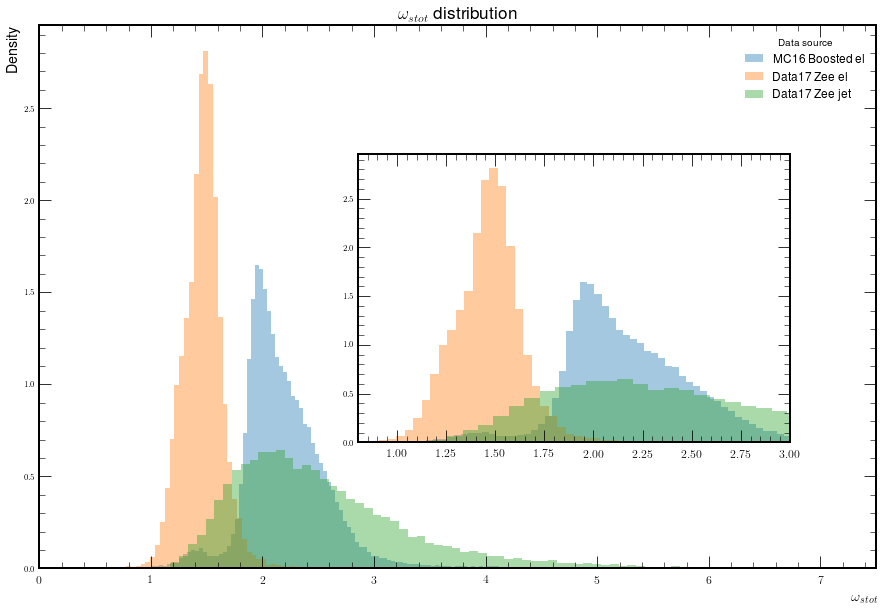

In [21]:
sub_ax_pos = [0.42, 0.3, 0.4, 0.4]
fig, ax = plt.subplots(1,1, figsize=(15,10))
zoomed_ax = fig.add_axes(sub_ax_pos)
subsampled_hists = dict()
for hist_name, hist_df in hists.items():
    ax.bar(hist_df['bin_start'], hist_df['hist'], align='edge', width=(hist_df['bin_end'] - hist_df['bin_start']), label=hist_name, alpha=0.4, bottom=0)
    zoomed_ax.bar(hist_df['bin_start'], hist_df['hist'], align='edge', width=(hist_df['bin_end'] - hist_df['bin_start']), label=hist_name, alpha=0.4, bottom=0)
# ax.set_xlim(-1e4, 0.4e6)
# ax.set_ylim(0, 5e-5)
zoomed_ax.set_xlim(0.8,3)
# ax.set_xlim(ss_info['jet_range'])
# zoomed_ax.set_xlim(ss_info['electron_range'])
ax.set_xlim(0,7.5)
ax.set_ylabel('Density')
ax.set_xlabel(ss_info['label'])
ax.legend(title='Data source')
ax.set_title(f'{ss_info["label"]} distribution', fontsize='xx-large')

### Não sei o nome ainda
Para esse shower shape existe um pico de valores negativos para o bin de (-1000.000000,-993.993994) o restante dos valores são todos positivos. Essa caracter;ística e o fato que o nome da coluna começa com "e" me leva a entender que a grandeza representa alguma forma de energia e os valores em negativo são devido a algum erro na aquisiçào da medida.

In [22]:
hists = dict()
plot_ss = 'e2tsts1'
ss_info = SHOWER_SHAPES[plot_ss]
ss_col = STEP_PREFIX[ss_info['step']] + plot_ss

# boosted_in_range = boosted_data[ss_col].between(*ss_info['range'])
# boosted_bins =  np.linspace(0.007, 0.0071, num=10)
boosted_bins = np.linspace(0, 5000, num=1000)
boosted_valid = boosted_data[ss_col] >= 0
# boosted_hist, _ = np.histogram(boosted_data.loc[boosted_in_range, ss_col], bins=boosted_bins, density=True)
boosted_hist, boosted_bins = np.histogram(boosted_data.loc[:, ss_col], bins=boosted_bins, density=True)
hists['MC16 Boosted el'] = pd.DataFrame(np.column_stack([boosted_bins[:-1], boosted_bins[1:], boosted_hist]),
                                        columns=HIST_DF_COLS)

# collision_in_range = collision_data[ss_col].between(*ss_info['range'])
el_bins = boosted_bins
collision_valid = collision_data[ss_col] >= 0
el_hist, el_bins = np.histogram(collision_data.loc[collision_data['electron'], ss_col], bins=el_bins, density=True)
hists['Data17 Zee el'] = pd.DataFrame(np.column_stack([el_bins[:-1], el_bins[1:], el_hist]),
                                        columns=HIST_DF_COLS)

jet_bins = np.linspace(0, 20000, num=1000)
jet_hist, jet_bins = np.histogram(collision_data.loc[collision_data['jet'], ss_col], bins=jet_bins, density=True)
hists['Data17 Zee jet'] = pd.DataFrame(np.column_stack([jet_bins[:-1], jet_bins[1:], jet_hist]),
                                        columns=HIST_DF_COLS)

Text(0.5, 1.0, 'no label distribution')

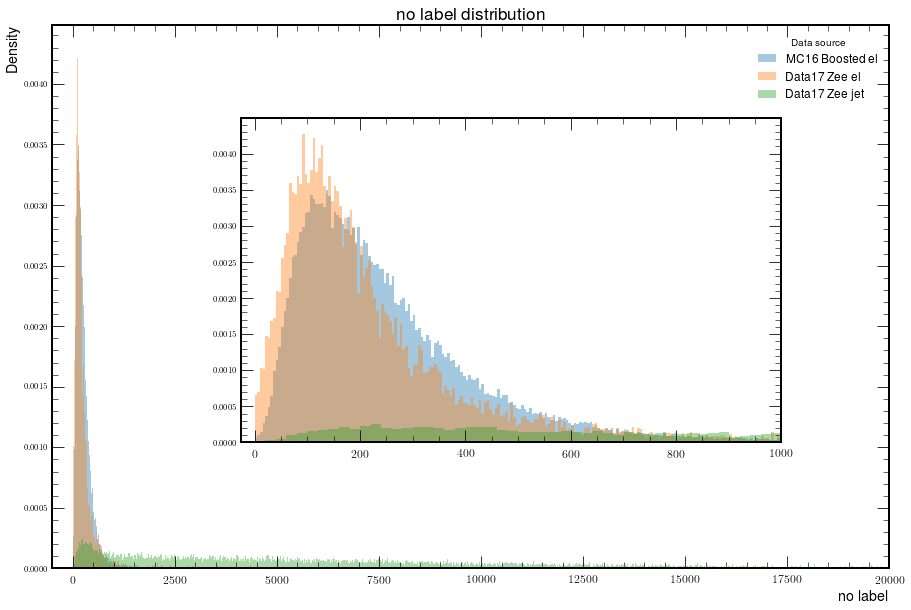

In [23]:
sub_ax_pos = [0.3, 0.3, 0.5, 0.45]
fig, ax = plt.subplots(1,1, figsize=(15,10))
zoomed_ax = fig.add_axes(sub_ax_pos)
subsampled_hists = dict()
for hist_name, hist_df in hists.items():
    ax.bar(hist_df['bin_start'], hist_df['hist'], align='edge', width=(hist_df['bin_end'] - hist_df['bin_start']), label=hist_name, alpha=0.4, bottom=0)
    zoomed_ax.bar(hist_df['bin_start'], hist_df['hist'], align='edge', width=(hist_df['bin_end'] - hist_df['bin_start']), label=hist_name, alpha=0.4, bottom=0)
# ax.set_ylim(0, 5e-5)
# zoomed_ax.set_xlim(ss_info['electron_range'])
zoomed_ax.set_xlim(-25, 1e3)
ax.set_xlim(-0.5e3, 20e3)
ax.set_ylabel('Density')
ax.set_xlabel(ss_info['label'])
ax.legend(title='Data source')
ax.set_title(f'{ss_info["label"]} distribution', fontsize='xx-large')

In [24]:
plt.close('all')